## Import package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, BatchNormalization, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
import time

%matplotlib inline

C:\Users\f2002\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\f2002\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Users\f2002\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _registe

## Get the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat((train_text, test_text))
print('The train\'s shape is {}'.format(train.shape))
print('The test\'s shape is {}'.format(test.shape))

The train's shape is (159571, 8)
The test's shape is (153164, 2)


In [3]:
train_target = train.drop(['id', 'comment_text'], axis = 1)
print('The target\'s shape is {}'.format(train_target.shape))

The target's shape is (159571, 6)


## Display the target structure

In [4]:
train_target.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5,0,'num of labels')

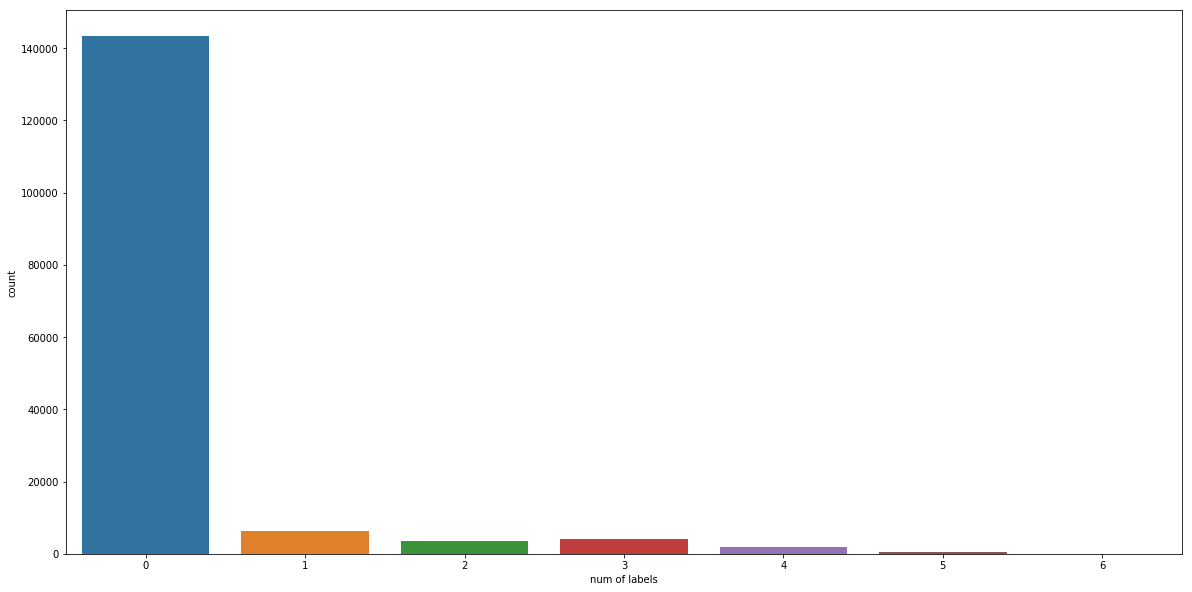

In [8]:
plt.subplots(figsize=(20, 10))
sb.countplot(data = train_target.sum(axis = 1), x = train_target.sum(axis = 1).index)
plt.xlabel('num of labels')

Text(0,0.5,'percentage of total labels')

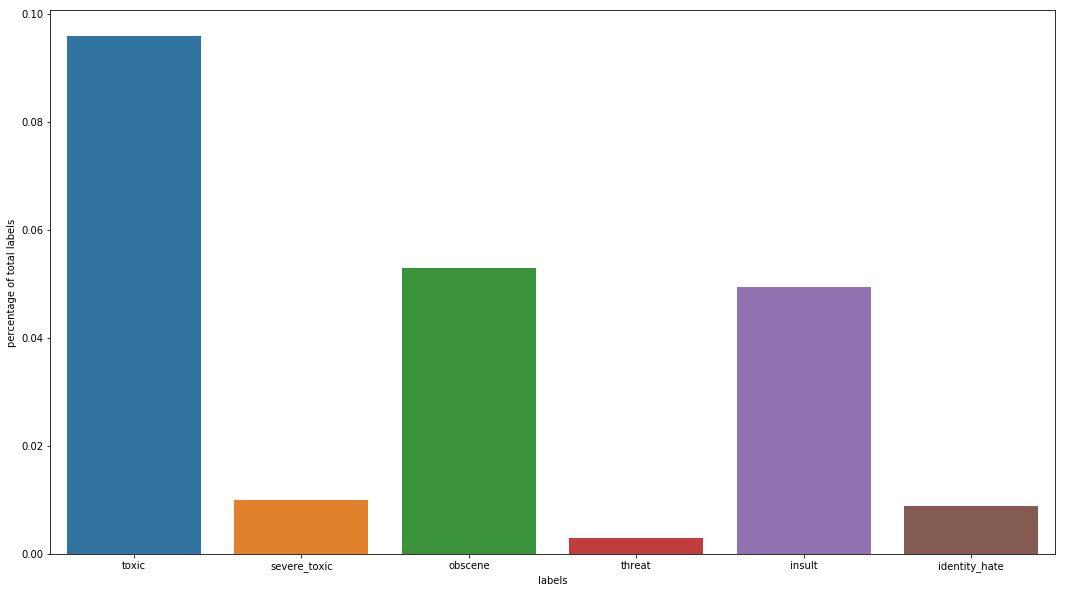

In [47]:
plt.subplots(figsize = (18, 10))
sb.barplot(x = train_target.sum().index, y = train_target.sum()/train_target.shape[0])
plt.xlabel('labels')
plt.ylabel('percentage of total labels')

As we seen above, this project is unbalance, and have multiple lables. 

In [5]:
lens = all_text.str.len()
print('The mean of total length is {}'.format(lens.mean()))
print('The std of total length is {}'.format(lens.std()))
print('The min of total length is {}'.format(lens.min()))
print('The max of total length is {}'.format(lens.max()))

The mean of total length is 379.7732617071962
The std of total length is 591.7677911923058
The min of total length is 1
The max of total length is 5000


Text(0,0.5,'counts')

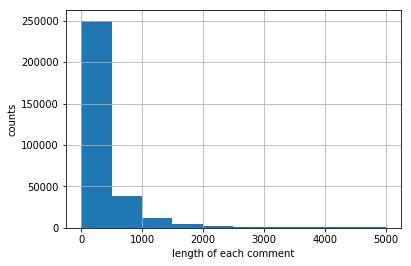

In [6]:
lens.hist()
plt.xlabel('length of each comment')
plt.ylabel('counts')

## Process the text data

#### tf-idf method

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)

vectorizer = make_union(word_vectorizer, char_vectorizer)

In [8]:
tf_start = time.time()
vectorizer.fit(all_text)
train_feature = vectorizer.transform(train_text)
test_feature = vectorizer.transform(test_text)
tf_end = time.time()
tf_time = tf_end - tf_start
print("tf-idf method used {} seconds".format(tf_time))

tf-idf method used 466.73894572257996 seconds


In [9]:
sample = train_text[0:1]
print(train_text[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [10]:
sample_feature = word_vectorizer.transform(sample)
word_array = sample_feature.toarray()
word_array.shape

(1, 30000)

#### GloVe method

In [11]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [12]:
glove_path_50d = open("F:\word2vec\glove\glove.6B.50d.txt", encoding = 'UTF-8')
glove_path_25d = open("F:\word2vec\glove\glove.twitter.27B.25d.txt", encoding = 'UTF-8')
glove_lines_50d = [line for line in glove_path_50d]
glove_lines_25d = [line for line in glove_path_25d]

In [13]:
def special_char(df, column):
    df[column] = df[column].str.replace(r"http\S+", "")
    df[column] = df[column].str.replace(r"http", "")
    df[column] = df[column].str.replace(r"@\S+", "")
    df[column] = df[column].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[column] = df[column].str.replace(r"@", "at")
    df[column] = df[column].str.lower()
    return df

In [14]:
def get_array(lines):
    key = lines[0]
    value = np.asarray(lines.split()[1:], dtype = 'float32')
    return key, value

In [15]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
stopwords = set(nltk.corpus.stopwords.words('english'))

In [16]:
gl_start = time.time()
train_clearn = special_char(train, 'comment_text')
train_clearn['comment_text'] = train_clearn['comment_text'].astype('str')
train_clearn['comment_text'] = train_clearn['comment_text'].apply(tokenizer.tokenize)
train_clearn['comment_text'] = train_clearn['comment_text'].apply(lambda vec: [word for word in vec if word not in stopwords])       
test_clearn = special_char(test, 'comment_text')
test_clearn['comment_text'] = test_clearn['comment_text'].astype('str')
test_clearn['comment_text'] = test_clearn['comment_text'].apply(tokenizer.tokenize)
test_clearn['comment_text'] = test_clearn['comment_text'].apply(lambda vec: [word for word in vec if word not in stopwords])

train_words = [word for tokens in train_clearn['comment_text'] for word in tokens]
train_sequence_length = [len(sequence) for sequence in train_clearn['comment_text']]
num_train_words = len(set(train_words))

test_words = [word for tokens in test_clearn['comment_text'] for word in tokens]
test_sequence_length = [len(sequence) for sequence in test_clearn['comment_text']]
num_test_words = len(set(test_words))

all_words = [train_words, test_words]

list_sentences_train = train['comment_text'].fillna('NA').values
list_sentences_test = test['comment_text'].fillna('NA').values

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(all_words))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen = maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen = maxlen)

word_dict = {}
for line in glove_lines_50d:
    key, value = get_array(line)
    word_dict[key] = value

all_emd = np.stack(word_dict.values())
mean_emd, std_emd = all_emd.mean(), all_emd.std()


word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(mean_emd, std_emd, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = word_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
gl_end = time.time()
gl_time = gl_end - gl_start
print('The shape of train features is {}'.format(X_train.shape))
print('The shape of test features is {}'.format(X_test.shape))
print("GloVe method used {} sceconds".format(gl_time))

The shape of train features is (159571, 100)
The shape of test features is (153164, 100)
GloVe method used 36.748377084732056 sceconds


C:\Users\f2002\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


### Implementation

#### RL

In [17]:
classes = []
for col in train_target:
    classes.append(col)
scores = []
result = pd.DataFrame({'id': test['id']})

In [22]:
lr_start = time.time()
for class_name in classes:
    target = train_target[class_name]
    classifier = LogisticRegression()
    #x_nv = get_nv(train_feature, target)
    cv_score = np.mean(cross_val_score(
        classifier, train_feature, target, cv=5, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    #plt_learning_curve(estimator = classifier, train_feature, target, train_size = np.linspace(0.1, 1.0, 10), scorer = 'roc_auc', cv = 5)
    #train_mean = np.mean(train_scores, axis = 1)
    #val_mean = np.mean(val_scores, axis = 1)
    #plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', label = 'training')
    #plt.plot(train_sizes, val_mean, color = 'red', marker = 'x', label = 'validation')
    #plt.grid()
    #plt.title(class_name)
    #plt.xlabel('Number of training sample')
    #plt.ylabel('ROC-AUC')
    #plt.ylim([0.8, 1.0])
    #plt.legend(loc = 'lower right')
    #plt.show()
    classifier.fit(train_feature, target)
    #predictions = classifier.predict(X_val)
    #score = roc_auc_score(predictions, y_val[class_name])
    #scores.append(score)
    #print('The auc score for class {} is {}'.format(class_name, score))    
    result[class_name] = classifier.predict_proba(test_feature)
lr_end = time.time()
lr_time = lr_end - lr_start
print('Total CV score is {}'.format(np.mean(scores)))
print('logisticregression method used {} seconds'.format(lr_time))


CV score for class toxic is 0.9790445977929293
CV score for class severe_toxic is 0.988638787302205
CV score for class obscene is 0.9903770335907931
CV score for class threat is 0.9894627831342815
CV score for class insult is 0.9831760654886482
CV score for class identity_hate is 0.9834212393149737
Total CV score is 0.9847378720595371
logisticregression method used 696.0699405670166 seconds


In [23]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.000097,0.775050,0.000302,0.94657,0.022016,0.729852
1,0000247867823ef7,0.993827,0.998004,0.996759,0.99959,0.995547,0.997945
2,00013b17ad220c46,0.989173,0.997714,0.992846,0.99938,0.996501,0.998758
3,00017563c3f7919a,0.996566,0.998763,0.997472,0.99922,0.997353,0.999408
4,00017695ad8997eb,0.982304,0.998538,0.995168,0.99924,0.994046,0.999081


Text(0,0.5,'probability')

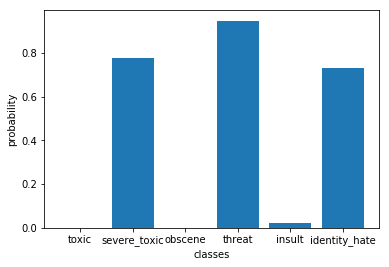

In [34]:
plt.bar(classes, result.loc[0].drop('id'))
plt.xlabel('classes')
plt.ylabel('probability')

#### LSTM

In [105]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch, score))
def schedule(ind):
    a = [0.000, 0.001, 0.002, 0.003, 0.004, 0.005]
    return a[ind]
lr = callbacks.LearningRateScheduler(schedule)
[X_tr, X_val, y_tr, y_val] = train_test_split(X_train, train_target, train_size=0.95)

ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

C:\Users\f2002\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [151]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(50, activation="relu")(x)
#x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model_l = Model(inputs=inp, outputs=x)

import keras.backend as K
def loss(y_true, y_pred):
     return K.binary_crossentropy(y_true, y_pred)
    
model_l.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])

In [152]:
ls_start = time.time()
history_l = model_l.fit(X_tr, y_tr, validation_data=(X_val, y_val), batch_size=64, epochs = 5, callbacks=[lr, ra_val])
ls_end = time.time()
ls_time = ls_end - ls_start
print('LSTM method used {} seconds'.format(ls_time))


Train on 151592 samples, validate on 7979 samples
Epoch 1/5
151592/151592 [==============================] - 598s 4ms/step - loss: 0.9772 - acc: 0.0455 - val_loss: 0.9250 - val_acc: 0.0312

 ROC-AUC - epoch: 0 - score: 0.530959
Epoch 2/5
151592/151592 [==============================] - 591s 4ms/step - loss: 0.0968 - acc: 0.7718 - val_loss: 0.0578 - val_acc: 0.9827

 ROC-AUC - epoch: 1 - score: 0.956950
Epoch 3/5
151592/151592 [==============================] - 593s 4ms/step - loss: 0.0582 - acc: 0.9582 - val_loss: 0.0516 - val_acc: 0.9921

 ROC-AUC - epoch: 2 - score: 0.974933
Epoch 4/5
151592/151592 [==============================] - 607s 4ms/step - loss: 0.0502 - acc: 0.9830 - val_loss: 0.0485 - val_acc: 0.9919

 ROC-AUC - epoch: 3 - score: 0.979979
Epoch 5/5
151592/151592 [==============================] - 612s 4ms/step - loss: 0.0463 - acc: 0.9683 - val_loss: 0.0480 - val_acc: 0.9694

 ROC-AUC - epoch: 4 - score: 0.980123
LSTM method used 3085.585523366928 seconds


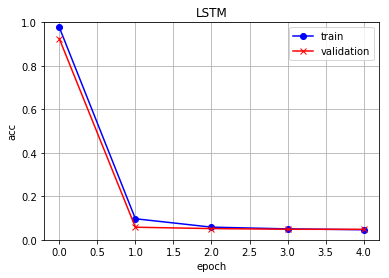

In [163]:
plt.plot(history_l.history['loss'], color = 'blue', marker = 'o', label = 'train')
plt.plot(history_l.history['val_loss'], color = 'red', marker = 'x', label = 'validation')
plt.title('LSTM')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc = 'upper right')
plt.ylim([0, 1])
plt.show()


#### GRU

In [153]:
inp = Input(shape=(maxlen, ))
g = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
g = Bidirectional(GRU(100, return_sequences=True))(g)
g = GlobalMaxPooling1D()(g)
g = BatchNormalization()(g)
g = Dense(50, activation = 'relu')(g)
#g = Dropout(0.1)(g)
g = Dense(6, activation="sigmoid")(g)
    
model_g = Model(inputs=inp, outputs=g)
model_g.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [154]:
g_start = time.time()
history_g = model_g.fit(X_tr, y_tr, validation_data = (X_val, y_val), batch_size=64, epochs=5, callbacks = [lr, ra_val])
g_end = time.time()
g_time = g_end - g_start
print('GRU method used {} seconds'.format(g_time))


Train on 151592 samples, validate on 7979 samples
Epoch 1/5
151592/151592 [==============================] - 472s 3ms/step - loss: 0.7311 - acc: 0.5963 - val_loss: 0.7317 - val_acc: 0.5966

 ROC-AUC - epoch: 0 - score: 0.528507
Epoch 2/5
151592/151592 [==============================] - 468s 3ms/step - loss: 0.0824 - acc: 0.9745 - val_loss: 0.0586 - val_acc: 0.9806

 ROC-AUC - epoch: 1 - score: 0.962603
Epoch 3/5
151592/151592 [==============================] - 467s 3ms/step - loss: 0.0547 - acc: 0.9808 - val_loss: 0.0532 - val_acc: 0.9821

 ROC-AUC - epoch: 2 - score: 0.978777
Epoch 4/5
151592/151592 [==============================] - 465s 3ms/step - loss: 0.0471 - acc: 0.9825 - val_loss: 0.0487 - val_acc: 0.9825

 ROC-AUC - epoch: 3 - score: 0.980251
Epoch 5/5
151592/151592 [==============================] - 465s 3ms/step - loss: 0.0436 - acc: 0.9833 - val_loss: 0.0495 - val_acc: 0.9816

 ROC-AUC - epoch: 4 - score: 0.979757
GRU method used 2409.7065284252167 seconds


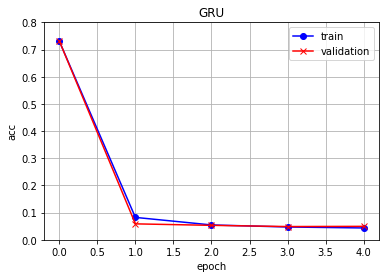

In [162]:
plt.plot(history_g.history['loss'], color = 'blue', marker = 'o', label = 'train')
plt.plot(history_g.history['val_loss'], color = 'red', marker = 'x', label = 'validation')
plt.grid()
plt.title('GRU')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc = 'upper right')
plt.ylim([0, 0.8])
plt.show()